# Image Captioning Model

Clip Prefix Model for Image Captioning using MS COCO Dataset

In [ ]:
!pip install transformers
! pip install git+https://github.com/openai/CLIP.git

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# START: COPIED FROM <https://github.com/rmokady/clip_prefix_caption>
# use PyDrive for downloading
download_with_pydrive = True

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_id, file_dst):
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)        # load MS COCO Dataset

In [3]:
import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
from google.colab import files
import skimage.io as io
import PIL.Image
from IPython.display import Image
from enum import Enum
import torch.nn as nn



N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")   # pre-trained CLIP model and it's model weights
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, 'model_wieghts.pt')

Model

In [4]:
# Mapping types - mlp (Multi-Layer Perceptron), Transformer Architecture
class MappingType(Enum):
    MLP = 'mlp'
    Transformer = 'transformer'

# a custom Multi-Layer Perceptron (MLP) layer
class MlpTransformer(nn.Module):
     def __init__(self, in_dim, h_dim, out_d: Optional[int] = None, act=nnf.relu, dropout=0.):
         super().__init__()
         out_d = out_d if out_d is not None else in_dim
         self.fc1 = nn.Linear(in_dim, h_dim)      # first fully-connected layer
         self.act = act                           # activation function (relu)
         self.fc2 = nn.Linear(h_dim, out_d)       # second fully-connected layer
         self.dropout = nn.Dropout(dropout)       # dropout layer for regularization

     # forward pass through MLP layer
     def forward(self, x):
         x = self.fc1(x)
         x = self.act(x)
         x = self.dropout(x)
         x = self.fc2(x)
         x = self.dropout(x)
         return x

# Multi-Layer Perceptron (MLP) model
class MLP(nn.Module):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))      # adding bias term as well to the Linear Layers
            if i < len(sizes) - 2:
                layers.append(act())       # add activation function (Tanh)
        self.model = nn.Sequential(*layers)    # create a Sequential Model


# define Multi-Head Attention layer for the Transformer Model
class MultiHeadAttention(nn.Module):

    def __init__(self, dim_self, dim_ref, num_heads, bias=True, dropout=0.):
        super().__init__()
        self.num_heads = num_heads                                              # number of attention head
        head_dim = dim_self // num_heads                                        # dimension of each attention head
        self.scale = head_dim ** -0.5                                           # scaling factor for attention scores
        self.to_queries = nn.Linear(dim_self, dim_self, bias=bias)              # Linear transformation for queries
        self.to_keys_values = nn.Linear(dim_ref, dim_self * 2, bias=bias)       # Linear transformation for key and values
        self.project = nn.Linear(dim_self, dim_self)                            # Linear Projection layer
        self.dropout = nn.Dropout(dropout)                                      # regularization

    # Forward pass through the Multi-Head Attention layer
    def forward(self, x, y=None, mask=None):
        y = y if y is not None else x
        b, n, c = x.shape     # batch size, sequence length and feature dimension of x
        _, m, d = y.shape     # " " of y

        # Apply linear transorfamtions to x and y
        # b n h dh
        queries = self.to_queries(x).reshape(b, n, self.num_heads, c // self.num_heads)
        # b m 2 h dh
        keys_values = self.to_keys_values(y).reshape(b, m, 2, self.num_heads, c // self.num_heads)

        # split key ad values
        keys, values = keys_values[:, :, 0], keys_values[:, :, 1]
        # compute attention scores
        attention = torch.einsum('bnhd,bmhd->bnmh', queries, keys) * self.scale
        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(1)    # Add a dimension for broadcasting
            attention = attention.masked_fill(mask.unsqueeze(3), float("-inf"))    # apply mask to attention score
        attention = attention.softmax(dim=2)    # # Apply softmax to compute attention weights
        out = torch.einsum('bnmh,bmhd->bnhd', attention, values).reshape(b, n, c)     # use attention weights to compute output
        out = self.project(out)
        return out, attention

# Transformer Layer using attention
class TransformerLayer(nn.Module):

    def __init__(self, dim_self, dim_ref, num_heads, mlp_ratio=4., bias=False, dropout=0., act=nnf.relu,
                 norm_layer: nn.Module = nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim_self)
        self.attn = MultiHeadAttention(dim_self, dim_ref, num_heads, bias=bias, dropout=dropout)  # use Multi-Head Attention layer
        self.norm2 = norm_layer(dim_self)
        self.mlp = MlpTransformer(dim_self, int(dim_self * mlp_ratio), act=act, dropout=dropout)  # mlp layer for feed-forward

    def forward_with_attention(self, x, y=None, mask=None):
      # Forward pass through the Transformer Layer with attention scores
        x_, attention = self.attn(self.norm1(x), y, mask)
        x = x + x_
        x = x + self.mlp(self.norm2(x))
        return x, attention

    def forward(self, x, y=None, mask=None):
      # # Forward pass through the Transformer Layer without attention scores
        x = x + self.attn(self.norm1(x), y, mask)[0]
        x = x + self.mlp(self.norm2(x))
        return x

# Transformer model
class Transformer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        attentions = []
        for layer in self.layers:
            x, att = layer.forward_with_attention(x, y, mask)
            attentions.append(att)
        return x, attentions

    def forward(self, x, y=None, mask=None):
        for i, layer in enumerate(self.layers):
            if i % 2 == 0 and self.enc_dec: # cross
                x = layer(x, y)
            elif self.enc_dec:  # self
                x = layer(x, x, mask)
            else:  # self or cross
                x = layer(x, y, mask)
        return x

    def __init__(self, dim_self: int, num_heads: int, num_layers: int, dim_ref: Optional[int] = None,
                 mlp_ratio: float = 2., act=nnf.relu, norm_layer: nn.Module = nn.LayerNorm, enc_dec: bool = False):
        super(Transformer, self).__init__()
        dim_ref = dim_ref if dim_ref is not None else dim_self
        self.enc_dec = enc_dec
        if enc_dec:
            num_layers = num_layers * 2    # Double the number of layers for encoder-decoder
        layers = []
        for i in range(num_layers):
            if i % 2 == 0 and enc_dec:
            # create a TransformerLayer for cross-attention
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            elif enc_dec:  # self
            # create a TransformerLayer for self-attention
                layers.append(TransformerLayer(dim_self, dim_self, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            else:  # self or cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
        self.layers = nn.ModuleList(layers)


class TransformerMapper(nn.Module):

    def forward(self, x):
        x = self.linear(x).view(x.shape[0], self.clip_length, -1)
        prefix = self.prefix_const.unsqueeze(0).expand(x.shape[0], *self.prefix_const.shape)
        prefix = torch.cat((x, prefix), dim=1)
        out = self.transformer(prefix)[:, self.clip_length:]
        return out

    def __init__(self, dim_clip: int, dim_embedding: int, prefix_length: int, clip_length: int, num_layers: int = 8):
        super(TransformerMapper, self).__init__()
        self.clip_length = clip_length
        self.transformer = Transformer(dim_embedding, 8, num_layers)
        self.linear = nn.Linear(dim_clip, clip_length * dim_embedding)
        self.prefix_const = nn.Parameter(torch.randn(prefix_length, dim_embedding), requires_grad=True)   # learnable prefix constant


# a custom ClipCaptionModel based on GPT-2
class ClipCaptionModel(nn.Module):

    # Generate a dummy token for captions
    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: torch.Tensor, prefix: torch.Tensor, mask: Optional[torch.Tensor] = None,
                labels: Optional[torch.Tensor] = None):
        embedding_text = self.gpt.transformer.wte(tokens)    # Get text embeddings using GPT-2's word embedding layer
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)     # Project the prefix to match the GPT-2 embedding size
        # Concatenate prefix projections and text embeddings along the sequence length dimension
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)

        # If labels are provided, concatenate a dummy token to the beginning of each sequence
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)

        # Forward pass through the GPT-2 model with the concatenated embeddings
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, clip_length: Optional[int] = None, prefix_size: int = 512,
                 num_layers: int = 8, mapping_type: MappingType = MappingType.MLP):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]      # Get GPT-2 embedding size
        if mapping_type == MappingType.MLP:
          # Use an MLP for clip-to-caption mapping (based on the mapping-type chosen)
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2,
                                     self.gpt_embedding_size * prefix_length))
        else:
          # Use a Transformer-based mapper for clip-to-caption mapping
            self.clip_project = TransformerMapper(prefix_size, self.gpt_embedding_size, prefix_length,
                                                                     clip_length, num_layers)

class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()   # Return parameters of the clip projection layer

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

Functions to geenrate captions (Beam Search and Top-p nucleus sampling)

In [5]:
def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()  # caption generation model chosen
    stop_token_index = tokenizer.encode(stop_token)[0]     # The tokenizer used for encoding and decoding text (get index of the stop token)
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)     # initialize sequence length
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)    # initialize stop flags
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)

        # generate a caption one token at a time
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits     # unnormalized scores associated with each token in the vocabulary
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)            # controls the degree of randomness in the generated text
            logits = logits.softmax(-1).log()    #compute log probabilities

            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)           # initialize scores and next tokens (The top-k tokens with the highest probabilities are selected)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)              # logits set to negative infinity to prevent them from being selected again
                logits[is_stopped, 0] = 0                        # The first token (which represents the end token) of previously stopped sequences is set to 0
                scores_sum = scores[:, None] + logits            # score of active sequence are summed
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]      # compute average scores
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]            # The top-k tokens with the highest average scores are selected.
                seq_lengths = seq_lengths[next_tokens_source]                      # indices mapped back to source sequences
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]              # output_texts : the decoded text for each generated caption
    return output_texts

# generate captions using top-p sampling
def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()                 # disable dropout and batch normalization layers, ensuring consistent and deterministic behavior during inference
    generated_num = 0            # keep track of the number of generated text samples
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:              # pre-computed embeddings
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                # A top-p (nucleus) sampling strategy is applied to filter out low-probability tokens
                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p                          # remove or don't include if prob > top_p prob
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0              # first element is kept (ensuring at least one token is selected)

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)      # token with the highest probability is selected
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

# END: COPIED FROM <https://github.com/rmokady/clip_prefix_caption>

In [6]:
downloader.download_file("1GYPToCqFREwi285wPLhuVExlz7DDUDfJ", model_path)

In [7]:
is_gpu = True
device = CUDA(0) if is_gpu else "cpu"
clip_model, preprocess = clip.load("RN50x4", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

100%|███████████████████████████████████████| 402M/402M [00:08<00:00, 48.4MiB/s]


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
loaded_state_dict = torch.load(model_path, map_location='cpu')
print(loaded_state_dict.keys())

In [ ]:
# nstantiate the model
model = ClipCaptionPrefix(prefix_length=40, clip_length=40, prefix_size=640, num_layers=8, mapping_type='transformer')

# model's state dict keys
print(model.state_dict().keys())

In [10]:
model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=False)

# Set the model to evaluation mode and use GPU is available
model = model.eval()
device = torch.device("cuda:0" if is_gpu else "cpu")
model = model.to(device)

Generate Caption for a Sample Image

In [ ]:
# upload Image
uploaded = files.upload()

if not uploaded:
  UPLOADED_FILE = ''
elif len(uploaded) == 1:
  UPLOADED_FILE = list(uploaded.keys())[0]

print(UPLOADED_FILE)

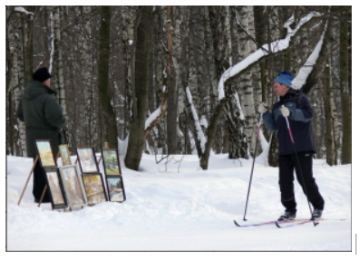



A couple of people that are standing in the snow.


In [12]:
use_beam_search = True
prefix_length = 40

image = io.imread(UPLOADED_FILE)
pil_image = PIL.Image.fromarray(image)
#pil_img = Image(filename=UPLOADED_FILE)
display(pil_image)

image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix = prefix / prefix.norm(2, -1).item()
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
if use_beam_search:
    generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
else:
    generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)


print('\n')
print(generated_text_prefix)

Test the model using the Flickr8k dataset

In [13]:
import random
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/ic_data/archive.zip

In [24]:
image_path = 'Images'

In [25]:
flickr8k_data = pd.read_csv("captions.txt")
flickr8k_data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [26]:
import pandas as pd
import os
from PIL import Image
import torch
from torchvision import transforms
from nltk.translate.bleu_score import corpus_bleu

In [27]:
from nltk.translate.bleu_score import SmoothingFunction

# Function to generate caption for an image
def generate_caption_for_image(image_path):
    pil_image = PIL.Image.open(image_path)
    image = preprocess(pil_image).unsqueeze(0).to(device)
    with torch.no_grad():
        prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
        prefix = prefix / prefix.norm(2, -1).item()
        prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
    if use_beam_search:
        generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
    else:
        generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
    return generated_text_prefix


### Automatic Evaluation (BLUE Scores)

In [30]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

chencherry = SmoothingFunction()           # Smoothing to get better BLUE scores

bleu_scores = []
generated_captions = {}  # Dictionary to store generated captions

# Process each image in the order they appear in the dataset (Initial 150 images)
for index, row in flickr8k_data.head(150).iterrows():
    img_name = row['image']
    if img_name not in generated_captions:
        caption = generate_caption_for_image(os.path.join(image_path, img_name))
        generated_captions[img_name] = caption  # Store the generated caption

        actual_captions = flickr8k_data[flickr8k_data['image'] == img_name]['caption'].tolist()
        references = [[caption.split() for caption in actual_captions]]
        candidate = caption.split()

        # Use smoothing function in BLEU score calculation
        bleu_score = corpus_bleu(references, [candidate], smoothing_function=chencherry.method1)
        bleu_scores.append(bleu_score)

average_bleu_score = sum(bleu_scores) / len(bleu_scores)

# Store image-caption pairs in sequence
with open('image_caption_pairs.txt', 'w') as file:
    for i, img_name in enumerate(flickr8k_data['image'].head(150).unique()):
        caption = generated_captions[img_name]
        file.write(f'{img_name}: {caption}\n')
        if (i + 1) % 3 == 0:
            file.write('\n')

print("Average BLEU Score with Smoothing:", average_bleu_score)

Average BLEU Score with Smoothing: 0.27505034824430373


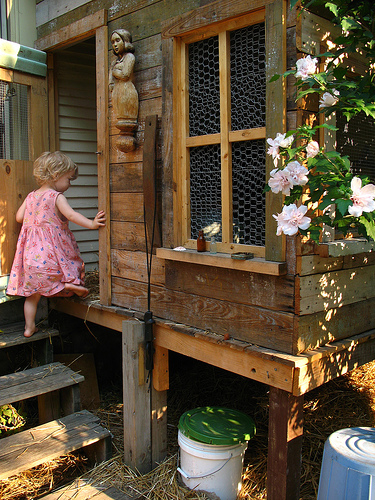

In [66]:
import pandas as pd
from PIL import Image
import IPython.display as display

for index, row in flickr8k_data.head(1).iterrows():
    img_name = row['image']
    # Load and display the image
    img_path = f"Images/{img_name}"  # Replace with the actual image directory path
    img = Image.open(img_path)
    display.display(img)

# Story Generation Model

### Zero-Shot GPT-2 Model
Generate Short Story Prompts for pair of three captions

In [ ]:
!git clone https://github.com/huggingface/transformers
!pip install transformers/
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers.optimization import AdamW, get_linear_schedule_with_warmup

In [68]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained model and tokenizer
model_name = "gpt2"  # GPT-2 model
tokenizer = GPT2Tokenizer.from_pretrained(model_name, padding_side='left')  # Set padding side to left
tokenizer.pad_token = tokenizer.eos_token  # Set the pad token
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

# Function generate a story from captions
def generate_story_from_captions(captions, prompt):
    # Combine the captions with the prompt
    input_text = f"{prompt} {captions}"

    # Encode the input text and create attention mask
    inputs = tokenizer(input_text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Adjust max_length if needed
    max_length_param = min(len(input_ids[0]) + 50, 1024)  # Add 50 tokens to input length but do not exceed 1024

    # generate a story
    story_ids = model.generate(input_ids, attention_mask=attention_mask, max_length=max_length_param, num_return_sequences=1, no_repeat_ngram_size=2, pad_token_id=tokenizer.eos_token_id)

    return tokenizer.decode(story_ids[0], skip_special_tokens=True)

# Read and process the image-caption pairs from the file
stories = []
with open('image_caption_pairs.txt', 'r') as file:
    lines = file.read().split('\n\n')

for group in lines:
    if group.strip():  # Checking if the group is not empty
        captions = [line.split(': ')[1] for line in group.split('\n') if ': ' in line]

        if len(captions) == 3:
            prompt = "Use all the three captions and generate a short story:"
            story = generate_story_from_captions(' '.join(captions), prompt)
            stories.append(story)

# Store the generated stories in a new file
with open('generated_stories.txt', 'w') as file:
    for story in stories:
        file.write(story + '\n\n---\n\n')

# Print the first element from 'image_caption_pairs.txt'
with open('image_caption_pairs.txt', 'r') as file:
    first_line = file.readline()
    print("First element in image_caption_pairs.txt:")
    print(first_line)

# Print the first element from 'generated_stories.txt'
with open('generated_stories.txt', 'r') as file:
    first_line = file.readline()
    print("\nFirst element in generated_stories.txt:")
    print(first_line)

First element in image_caption_pairs.txt:
1000268201_693b08cb0e.jpg: A little girl in a pink dress sitting on a wooden bench.


First element in generated_stories.txt:
Use all the three captions and generate a short story: A little girl in a pink dress sitting on a wooden bench. A black and white dog and a black and white dog. A little girl sitting on a beach with an umbrella. The dog is a white and black dog with a red and blue collar.



### Fine-Tuned GPT-2 Model
Generates Creative Stories for the pair of three images

In [71]:
import argparse

In [72]:
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=88888)
parser.add_argument("--model_name", default="gpt2", type=str)
parser.add_argument("--max_seq_length", default=512, type=int)
parser.add_argument("--train_batch_size", default=4, type=int)
parser.add_argument("--valid_batch_size", default=4, type=int)
parser.add_argument("--num_train_epochs", default=1, type=int)
parser.add_argument("--warmup", default=0.1, type=float)
parser.add_argument("--learning_rate", default=5e-5, type=float)
parser.add_argument("--input_text_path", default='../input/story-text', type=str)
args, _ = parser.parse_known_args()

In [75]:
# Function to combine prompts and stories
def combinetext(prompt, story):
    prompts = open(prompt, 'r', encoding='utf8').readlines()
    stories = open(story, 'r', encoding='utf8').readlines()
    assert len(prompts) == len(stories)
    combine = []
    for i in range(len(prompts)):
        combine.append(prompts[i].rstrip() + ' <sep> ' + " ".join(stories[i].split()[:300]))
    return combine

# Preprocessing the data (punctuations, etc)
def cleanpunctuation(s):
    for p in '!,.:;?':
        s = s.replace(' ' + p, p)
    s = s.replace(' ' + 'n\'t', 'n\'t')
    s = s.replace(' ' + '\'s', '\'s')
    s = s.replace(' ' + '\'re', '\'re')
    s = s.replace(' ' + '\'ve', '\'ve')
    s = s.replace(' ' + '\'ll', '\'ll')
    s = s.replace(' ' + '\'am', '\'am')
    s = s.replace(' ' + '\'m', '\'m')
    s = s.replace(' ' + '\' m', '\'m')
    s = s.replace(' ' + '\'m', '\'m')
    s = s.replace(' ' + '\' ve', '\'ve')
    s = s.replace(' ' + '\' s', '\'s')
    s = s.replace('<newline>', '\n')
    return s

# Combine and clean text for train and valid datasets
train_text = combinetext('valid.wp_source', 'valid.wp_target')
train_text = list(map(cleanpunctuation, train_text))

valid_text = combinetext('test.wp_source', 'test.wp_target')
valid_text = list(map(cleanpunctuation, valid_text))

In [76]:
#tokenize an dload the dataloader
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token=tokenizer.eos_token

inputs_train = tokenizer(train_text, padding=True,truncation=True,max_length=args.max_seq_length)
inputs_valid=tokenizer(valid_text, padding=True,truncation=True,max_length=args.max_seq_length)

In [77]:
# creating labels sequence for every input_ids sequence
def create_labels(inputs):
    labels=[]
    for ids,attention_mask in zip(inputs['input_ids'],inputs['attention_mask']):
        label=ids.copy()
        real_len=sum(attention_mask)
        padding_len=len(attention_mask)-sum(attention_mask)
        label[:]=label[:real_len]+[-100]*padding_len          # rule out padding tokens by setting it to -100 (to avoid compute loss)
        labels.append(label)                                  # automatically shifts the labels to the right to match the inputs_ids
    inputs['labels']=labels

create_labels(inputs_train)
create_labels(inputs_valid)

In [78]:
class StoryDataset:
    def __init__(self, inputs):
        self.ids = inputs['input_ids']
        self.attention_mask = inputs['attention_mask']
        self.labels=inputs['labels']

    def __len__(self):
        return len(self.ids)         # total number of samples in the dataset

    def __getitem__(self, item):

        return [torch.tensor(self.ids[item], dtype=torch.long),
                torch.tensor(self.attention_mask[item], dtype=torch.long),
                torch.tensor(self.labels[item], dtype=torch.long)]

In [79]:
# train dataset
train_batch_size=args.train_batch_size
valid_batch_size=args.valid_batch_size
traindata=StoryDataset(inputs_train)
train_dataloader = torch.utils.data.DataLoader(
    traindata,
    shuffle=False,
    batch_size=train_batch_size)

# vaidation dataset
validdata=StoryDataset(inputs_valid)
valid_dataloader = torch.utils.data.DataLoader(
    validdata,
    shuffle=False,
    batch_size=valid_batch_size)

In [80]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [81]:
# Using generate function from the model
def generate_story(prompt, k=0, p=0.9, output_length=300, temperature=1, num_return_sequences=1, repetition_penalty=1.0):
    # print("--------The prompt is:\n")
    # print(prompt + "\n")

    encoded_prompt = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt")
    model.to('cpu')
    model.eval()
    output_sequences = model.generate(
        input_ids=encoded_prompt,
        max_length=output_length,
        temperature=temperature,                          # control next token probability
        top_k=k,                                          # number of highest probability vocabulary tokens to keep for top-k-filtering
        top_p=p,                                          # cumulative probability of parameter highest probability vocabulary tokens to keep for nucleus sampling
        repetition_penalty=repetition_penalty,            # Between 1.0 and infinity. 1.0 means no penalty
        do_sample=True,                                   # if set to False greedy decoding is used
        num_return_sequences=num_return_sequences
    )

    if len(output_sequences.shape) > 2:
        output_sequences.squeeze_()

    for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
        # print("-------Story {}:".format(generated_sequence_idx + 1))
        generated_sequence = generated_sequence.tolist()
        # Decode text
        text = tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True)
        # Remove all text after eos token
        text = text[: text.find(tokenizer.eos_token)]
        print(text)
        return(text)


In [ ]:
# number of training samples = 15620

num_train_epochs = args.num_train_epochs
training_steps_per_epoch=len(train_dataloader)
total_num_training_steps = int(training_steps_per_epoch*num_train_epochs)
weight_decay=0
learning_rate=args.learning_rate
adam_epsilon=1e-8
warmup_steps=int(total_num_training_steps*args.warmup)
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": weight_decay,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_num_training_steps
)

In [ ]:
#Train the model on GPU
import math
print("  Num Epochs = {}".format(num_train_epochs))
print(f"  Train_batch_size per device = {train_batch_size}")
print(f"  Valid_batch_size per device = {valid_batch_size}")
model.to('cuda')
for epoch in range(num_train_epochs):
    print(f"Start epoch{epoch+1} of {num_train_epochs}")
    train_loss=0
    epoch_iterator = tqdm(train_dataloader,desc='Iteration')
    model.train()
    model.zero_grad()
    for _, inputs in enumerate(epoch_iterator):
        d1,d2,d3=inputs
        d1=d1.to('cuda')
        d2=d2.to('cuda')
        d3=d3.to('cuda')
        output = model(input_ids=d1, attention_mask=d2,labels=d3)
        batch_loss=output[0]
        batch_loss.backward()
        optimizer.step()
        scheduler.step()
        model.zero_grad()
        train_loss+=batch_loss.item()
        epoch_iterator.set_description('(batch loss=%g)' % batch_loss.item())
        del batch_loss
    print(f'Average train loss per example={train_loss/training_steps_per_epoch} in epoch{epoch+1}')
    print(f'Starting evaluate after epoch {epoch+1}')
    eval_loss=[]
    model.eval()
    for inputs in tqdm(valid_dataloader, desc="eval"):
        d1,d2,d3=inputs
        d1=d1.to('cuda')
        d2=d2.to('cuda')
        d3=d3.to('cuda')
        with torch.no_grad():
            output = model(input_ids=d1, attention_mask=d2,labels=d3)
            batch_loss=output[0]
        eval_loss+=[batch_loss.cpu().item()]
        del batch_loss
    eval_loss=np.mean(eval_loss)
    perplexity=math.exp(eval_loss)
    print(f'Average valid loss per example={eval_loss} in epoch{epoch+1}')
    print(f'Perplextiy for valid dataset in epoch{epoch+1} is {perplexity}')

# Perplexity used as the metrics to check if fine-tuning imporves the performance or not

In [85]:
# Read stories from the file
with open('generated_stories.txt', 'r') as file:
    original_stories = file.read().split('\n\n---\n\n')

extended_stories = []

# Generate extended content for each story
for story in original_stories:
    if story.strip():  # Ensure the story is not empty
        extended_story = generate_story(story)
        if extended_story:
            # Split the story at line breaks and take the part after the first line
            story_parts = extended_story.split('\n')
            if len(story_parts) > 1:
                extended_story = '\n'.join(story_parts[1:])
            extended_stories.append(extended_story)
        else:
            extended_stories.append("Story extension failed.")  # Placeholder for failed generations

# Save the modified stories to a new file
with open('creative_stories.txt', 'w') as file:
    for story in extended_stories:
        file.write(story + '\n\n---\n\n')

# Print the First Creative Story generated for the pair of three images
print("\nFirst creative story from the file:")
if original_stories:
    print(original_stories[0])
else:
    print("No creative stories found in the file.")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Use all the three captions and generate a short story: A little girl in a pink dress sitting on a wooden bench. A black and white dog and a black and white dog. A little girl sitting on a beach with an umbrella. The dog is a white and black dog with a red and blue collar.

The story is about a girl who is in love with her dog, and she is trying to get her to stop. She is told that she has to go to the park when she is in danger. But she does not want to go. She has never been to the park before. She is scared of the dog, but that is what she wants. She then asks the dog a number. The number is `` 800-888-1623. '' The dog replies, `` I'm sorry. ''. The dog is then disappointed and begins to bark. He does not understand her since she is a public school girl. She falls over and begs him not to bark. He does not listen, but tells her, `` What do you want? '' Then he kills the dog. The girl is in tears as he kills her. Then he kisses her and she places the pile of poop in his lap. Then he k

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Use all the three captions and generate a short story: A man laying on a bench next to a dog. A man with a hat on his head. A little girl holding onto a ladder holding onto a rope.

The story is a bit of a mess, but it's a good one. It's about a man who is trying to get his life together, and he's trying not to be a burden to his family. He's not trying for sympathy, he's trying to create. It's not one paragraph long. The story has to end with someone comforting the family, whatever that is. It starts with a boy sobbing on his mother's couch. He sits there crying, as though someone is going to come over and take care of the kids in his life. Then he just sits there and listens. He's not going to talk about how much he hurts, how hurt he gets. He's a terrible parent. He doesn't seem to care how his children die, or how he makes sure he meets them. Or what color life is, or if it has a black person, or a white person. He just seems to stay quiet. The main character, Nathan, is also cryin

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Use all the three captions and generate a short story: A dog running in the grass near a ball. A dog playing with a ball on the beach. A young boy is playing with a skateboard.

The story is about a dog who is running around the ball in a grassy area. The dog is a little boy who has been running for a long time. He is trying to get to the end of the field. When he gets there, the boy is jumping off of the small mountain. The dog keeps running and he sees a small road. Inside the road, the dog sees the trails. The boy never sees them. This is where the story takes place. The dog runs. He is running and the boy reaches the end of the field. That's when the story begins.

This is a typical tale. The boy is running. It is pretty normal for dogs to do things. They run off when they get to the end of the field. It's normal. It's the most normal way for dogs to get to the end of the field. The boy, at the end of the field, runs. He doesn't even notice his work, he runs slowly. He runs slowly.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Use all the three captions and generate a short story: A dog that is jumping in the air. A dog that is running in the snow. A woman standing next to some skis in the snow.

The story is a bit of a mess, but it's a good one. It's about a dog who is trying to get out of the way of some snow, and he's trying not to fall into it. He's not trying to be clumsy or out of control. He's just trying to try and stay out of the way of it, and not fall into it. It's not a good story and for the most part it's been made up. Of course you don't want to read one that needs saving. It may take longer than you think it will. For me, writing a story where you're supposed to be careful and check to make sure you don't drown in the stream of people falling, and then just show up with somebody nearby and be good with them. Just not in the way that the series should be!

But it's pretty sweet, actually, because of the writing, where this book should be one of those long stories that can only be adapted by so

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Use all the three captions and generate a short story: A group of people are climbing onto a rock wall. A dog playing with a frisbee in the grass. A dog is jumping in the air to catch a frisbee. The dog's head is on the rock.

The story is about a group who are trying to climb a wall in a park. They are all trying their best to get to the top of the wall, but the dog jumps in front of them and jumps into the air. You can see the dog's tail. The dog gets pissed and grabs the frisbee. The dog hops up to catch the frisbee and throws it at the wall. The wall slaps the dog's head back. The dog grabs the frisbee and throws it at the wall. The wall slaps the dog's head back. The dog grabs the frisbee and throws it at the wall. The wall lifts up, and the dog takes the dog by the arm and puts it back down on the rock. The wall drops to the ground and the dog drops to the ground. The dog makes its way towards the wall and reaches in. The wall drops to the ground and the dog pulls back on the fri

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Use all the three captions and generate a short story: A dog jumps in the air to catch a frisbee. A little boy flying a kite next to a body of water. A baby sitting on a bench next to a stroller.

The story is a bit of a mess, but it's a good one. The story starts with a dog jumping in a watery pond. It's not a bad idea to have a story like that, especially if you're a kid. I figured I would share the egg laying message below.

If you like the story, then you can leave a comment below or on our Facebook page for a prompt. It's best to get it in a few days, but it's also a good way to turn a nice summer day into a very happy and exciting night. And of course, if you're cool with it, if it's not a good idea to share, please let us know!

-Kelly

Photos by Melissa with Frank,

By Francesconi Maricich. He also writes about animals in Polish. Thanks for taking the time to check it out! Hope you enjoyed it, and enjoy the blog and the kid work!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Use all the three captions and generate a short story: A dog in the water with a ball in his mouth. A person on skis in the snow. Two dogs playing together on the beach.

The story is a bit of a mess, but it's a good one. The story starts with the dog, and the story ends with him. It's not a bad story, because it is. But it doesn't have the same feel, which makes it entertaining to read. 
 
 The story opens with a loud and sombre chirping. The dog straddles the ship, clearly distraught. He can still see that the lamp is brighter than the TV. This is weird, because he has those orange eyes, and there is no way he can see the battery inside his kennel. When they first hit the water, she seemed to have been overly afraid, and she burst into tears while I put her face right next to her mouth. 
 
 Then it was like he thought he had caught me sleeping. He realizes that I am the other one in this game. He doesn't like the name `` Wolf '' but I try my best to ignore him. He slowly realizes tha

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Use all the three captions and generate a short story: A person on skis in the snow. A black dog holding a frisbee in its mouth. A man and a child sit on a kayak in the water.

The story is a bit of a mystery, but it's a good one. The story begins with a man in a snowmobile riding his dog. He's wearing a white shirt and shorts, and he's holding his frisk. When he opens his mouth, there's a burst of air, and then he's in a few minutes. 
 
 After about 20 minutes, he's back in the kayak. It doesn't actually look like he's walking alone, it's just that there are strings of the road leading from one place to another. When the narrator starts to make eye contact with the dog and get him home, he changes the channel and goes the street, where he stops at a red dot on the picture below. A farmer tries to contact him through a fence in the middle of the street, but the dog stops him and jumps at his leash. He sprints to the house. 
 
 A man picks up a newspaper out of a mailbox and picks it up

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Use all the three captions and generate a short story: Two dogs are playing with a Frisbee in the yard. A young boy is bending over to hit a tennis ball. A statue of a man sitting on a metal bench. The man is holding a gun. He is trying to shoot the statue.

The story is about a young man who is a teacher at a school in a rural area of the United States. His teacher is an old man. When he is present his entire class decides to take a picture. The statue of the man is a painting of him with a gorilla clutching his arm. The statue is disturbing. One man tries to kill the statue. The other two students reluctantly kill him. One of them decides to stab his own hand so his hand keeps the picture. Another pushes the drawing in a swing of his saw. A big knife falls to the wall with a brilliant red arrow. The two get into a fight and the hanging man dies. Two people find him at a bus stop. Two old folks, yelling at the bus stop, get shot. One shoots the bus man in the face with a bat and the o

### Evaluation Metrics (Image-to-Story Pipeline)

New Metric (WorLap) - calculate the percentage of words from the pair of three captions that were present in the story generated by the final model, to test for coherency of the story with respect to the context and themes present in the pair of three sequential random images

In [91]:
def calculate_word_overlap(captions, story):
    # Create sets of unique words from captions and the story
    caption_words = set(word.lower() for caption in captions for word in caption.split())
    story_words = set(word.lower() for word in story.split())
    common_words = caption_words.intersection(story_words)

    # Calculate the percentage of caption words that appear in the story
    if not caption_words:
        return 0.0
    return (len(common_words) / len(caption_words)) * 100

# Read captions from image_caption_pairs.txt
with open('image_caption_pairs.txt', 'r') as file:
    caption_data = file.read().strip().split('\n\n')

# Process captions into groups of three
caption_groups = [[line.split(': ')[1] for line in group.split('\n')] for group in caption_data]

# Read stories from creative_stories.txt
with open('creative_stories.txt', 'r') as file:
    stories = file.read().strip().split('\n\n---\n\n')

# Calculate word overlap percentages for each story
overlap_percentages = [calculate_word_overlap(captions, story) for captions, story in zip(caption_groups, stories)]

# Calculate total average percentage of overlap
total_average_percentage = sum(overlap_percentages) / len(overlap_percentages)

# Print the total average percentage
print(f"Total Average Percentage of Word Overlap: {total_average_percentage:.2f}%")

Total Average Percentage of Word Overlap: 40.92%


### Automai Evaluation metrics
##### 1. Fluency and Readability
##### 2. Lexical Diversity
##### 3. Narrative Structure

In [ ]:
!pip install textstat
import textstat

In [88]:
#1. Fluency and Readability
# Using the Flesch-Kincaid readability test to measure the readability of your text.

def calculate_readability(text):
    return textstat.flesch_kincaid_grade(text)

# Read and process the creative stories
with open('creative_stories.txt', 'r') as file:
    stories = file.read().strip().split('\n\n---\n\n')

# Calculate readability for each story
readability_scores = [calculate_readability(story) for story in stories]

# Calculate and print the average readability score
average_readability = sum(readability_scores) / len(readability_scores)
print(f"Average Readability Score: {average_readability}")

Average Readability Score: 3.1999999999999997


In [92]:
#2. Lexical Diversity
# Using Type-Token Ratio (TTR) to measure the diversity of vocabulary.

def calculate_ttr(text):
    words = text.split()
    if not words:
        return 0.0
    unique_words = set(words)
    return len(unique_words) / len(words)

# Calculate TTR for each story
ttr_scores = [calculate_ttr(story) for story in stories]

average_ttr = sum(ttr_scores) / len(readability_scores)
print(f"Average Readability Score: {average_ttr}")

Average Readability Score: 0.5522282506410308


In [93]:
#3. Narrative Structure
# analyze simpler aspects like sentence length variability as a proxy for complexity:

def calculate_sentence_complexity(text):
    sentences = text.split('.')
    sentence_lengths = [len(sentence.split()) for sentence in sentences if sentence]
    if not sentence_lengths:
        return 0
    return max(sentence_lengths) - min(sentence_lengths)

# Calculate sentence complexity for each story
complexity_scores = [calculate_sentence_complexity(story) for story in stories]

average_complexity = sum(complexity_scores) / len(readability_scores)
print(f"Average Readability Score: {average_complexity}")

Average Readability Score: 27.3
